In [ ]:
import matplotlib.pyplot as plt
import os
from google.colab import drive
import numpy as np
import tensorflow as tf
import copy
import sklearn.linear_model as lm
import sklearn.preprocessing
import warnings
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

In [ ]:
#download data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
nx_train, nx_test = x_train/255, x_test/255
sx_train, sx_test = sklearn.preprocessing.scale(x_train.reshape(60000, 28*28)), sklearn.preprocessing.scale(x_test.reshape(10000, 28*28))
print(y_train)

11493376/11490434 [==============================] - 0s 0us/step
[5 0 4 ... 5 6 8]


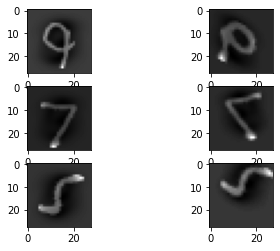

In [ ]:
#Augment data
IDG = ImageDataGenerator(rotation_range=60, 
                         width_shift_range=0.25, 
                         height_shift_range=0.25, 
                         brightness_range=(0.2, 1), 
                         shear_range=30, 
                         fill_mode='constant', 
                         cval=0.0,
                         horizontal_flip=True,
                         vertical_flip = True,
                         )
augmented_train = IDG.flow(x = sx_train.reshape(-1, 28, 28, 1), y = y_train, batch_size=60000, seed=0, shuffle=False )
augmented_test  = IDG.flow(x = sx_test.reshape(-1, 28,28,1), y=y_test, batch_size=10000, seed=0, shuffle=False)
# print(augmented_test.next()[0].shape)
augmented_train_x, augmented_train_y = augmented_train.next()
augmented_test_x, augmented_test_y = augmented_test.next()
plt.subplot(3,2,1)
plt.imshow(sx_test[999].reshape(28,28), cmap='gray')
plt.subplot(3,2,2)
plt.imshow(augmented_test_x[99].reshape(28,28), cmap='gray')
plt.subplot(3,2,3)
plt.imshow(sx_test[0].reshape(28,28), cmap='gray')
plt.subplot(3,2,4)
plt.imshow(augmented_test_x[0].reshape(28,28), cmap='gray')
plt.subplot(3,2,5)
plt.imshow(sx_train[11739].reshape(28,28), cmap='gray')
plt.subplot(3,2,6)
plt.imshow(augmented_train_x[11739].reshape(28,28), cmap='gray')

(60000, 28, 28, 1)
(60000, 784)


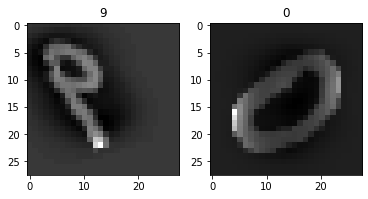

In [ ]:
#create hybrid dataset 
from sklearn.utils import shuffle
print(augmented_train_x.shape)
print(sx_train.shape)
hybrid_x_train = np.concatenate((augmented_train_x[0:30000], sx_train[30000:].reshape(-1,28,28,1)))
hybrid_x_train, hybrid_y_train = shuffle(hybrid_x_train, y_train, random_state=0) 
hybrid_x_test= np.concatenate((augmented_test_x[0:5000], sx_test[5000:].reshape(-1,28,28,1)))
hybrid_x_test, hybrid_y_test= shuffle(hybrid_x_test, y_test, random_state=0) 
plt.subplot(1,2,1)
plt.title(hybrid_y_train[900])
plt.imshow(hybrid_x_train[900].reshape(28,28), cmap='gray')
plt.subplot(1,2,2)
plt.title(hybrid_y_test[990])
plt.imshow(hybrid_x_test[990].reshape(28,28), cmap='gray')

In [ ]:
#load already trained models and evaluate accuracy for each dataset (upload to /content directory)
model = load_model('plain_mnist.h5')
augmented_model = load_model('augmented.h5')
hybrid_model = load_model('hybrid.h5')
model.evaluate(hybrid_x_test, hybrid_y_test)
augmented_model.evaluate(sx_test.reshape(-1, 28,28,1), y_test, )
augmented_model.evaluate(augmented_test_x, augmented_test_y)
augmented_model.evaluate(hybrid_x_test, hybrid_y_test)
hybrid_model.evaluate(sx_test.reshape(-1, 28,28,1), y_test, )
hybrid_model.evaluate(augmented_test_x, augmented_test_y)
hybrid_model.evaluate(hybrid_x_test, hybrid_y_test)

313/313 [==============================] - 54s 172ms/step - loss: 0.4211 - accuracy: 0.8877


[0.42108067870140076, 0.8877000212669373]

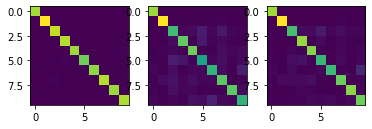

In [ ]:
predictions_plain = tf.argmax(model.predict(sx_test.reshape(-1,28,28,1)), axis=1)
predictions_augmented = tf.argmax(augmented_model.predict(augmented_test_x), axis=1)
predictions_hybrid = tf.argmax(hybrid_model.predict(hybrid_x_test), axis=1)


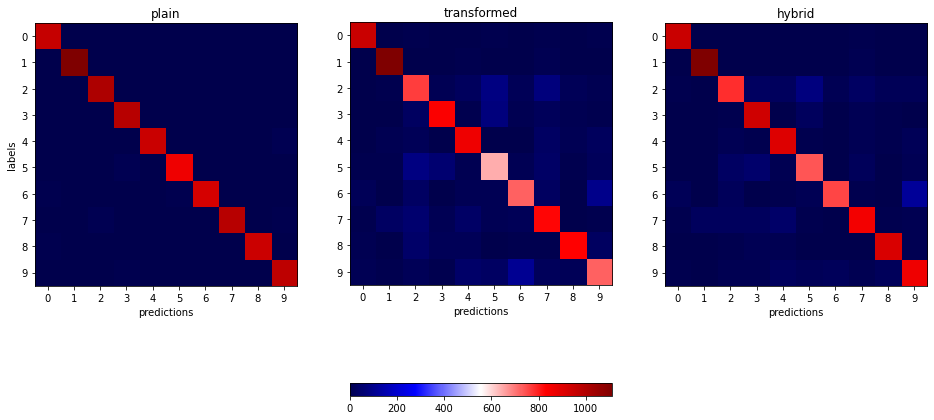

In [ ]:
confusion_plain = tf.math.confusion_matrix(y_test, predictions_plain)
confusion_augmented = tf.math.confusion_matrix(augmented_test_y, predictions_augmented)
confusion_hybrid = tf.math.confusion_matrix(hybrid_y_test, predictions_hybrid)
plt.figure(figsize=(16,12))
plt.subplot(1, 3,1)
plt.xlabel('predictions')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
plt.ylabel('labels')
plt.imshow(confusion_plain, cmap='seismic')
plt.title('plain')
plt.subplot(1, 3,2)
plt.xlabel('predictions')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
plt.imshow(confusion_augmented, cmap='seismic')
plt.colorbar(orientation='horizontal')
plt.title('transformed')
plt.subplot(1, 3,3)
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
plt.xlabel('predictions')
plt.title('hybrid')
plt.imshow(confusion_hybrid,  cmap='seismic')

(10000, 10)


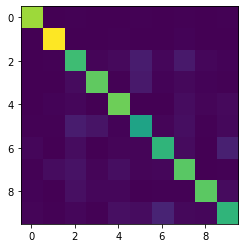

In [ ]:
print(predictions_plain.shape)
plt.imshow(tf.math.confusion_matrix(y_test, y_plain_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(5, 5, 56, 784)


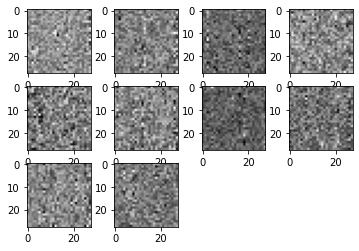

In [ ]:
W, b = np.array(model.layers[1].get_weights())
def visualize_filters(V):
    k, m, n = V.shape
    ncol = 8                                     
    nrow = min(4, (k + ncol - 1) // ncol)        
    V = V[:nrow*ncol]                            
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])  
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5])) 
print(W.shape)
W = W.reshape(28,28,-1)
for i in range(10):
  plt.subplot(3,4,i+1)
  plt.imshow(W[:,:,i], cmap='gray')
# visualize_filters()

In [ ]:
print(sx_test.shape)
hybrid_model.evaluate(sx_test.reshape(-1,28,28,1), y_test)
# hybrid_model.save('hybrid.h5')
# np.save('augmented_train_x', augmented_train_x)
# np.save('augmented_train_y', augmented_train_y)
# np.save('augmented_test_x', augmented_test_x)
# np.save('augmented_test_y', augmented_test_y)
# np.save('hybrid_x_train', hybrid_x_train)
# np.save('hybrid_y_train', hybrid_y_train)
# np.save('hybrid_x_test', hybrid_x_test)
# np.save('hybrid_y_test', hybrid_y_test)

(10000, 784)
313/313 [==============================] - 1s 4ms/step - loss: 0.0484 - accuracy: 0.9846


[0.04842916503548622, 0.9846000075340271]

In [ ]:
#plain model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(28*2, 3, padding='same', activation='relu', input_shape=(28,28, 1)),
    tf.keras.layers.Conv2D(28*28, 5, padding='same', activation='relu', ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation='sigmoid')
  ]
)
x = sx_train.reshape(-1, 28,28,1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = copy.copy(model)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.fit(x,y_train, epochs=5, batch_size=1000)
model.evaluate(nx_test.reshape(-1, 28,28,1), y_test, )
model.save('plain_mnist.h5')


In [ ]:
#augmented model architecture and training
augmented_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 5, padding='same', activation='relu', input_shape=(28,28, 1)),
    tf.keras.layers.Conv2D(10*5, 3, padding='same', activation='relu', ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dense(28,activation='softmax'),
    tf.keras.layers.Conv2D(28, 5, padding='same', activation='relu', input_shape=(28,28, 1)),
    tf.keras.layers.Conv2D(28*28, 3, padding='same', activation='relu', ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation='softmax')
  ]
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
augmented_model.compile('adam', loss=loss, metrics=['accuracy'])
print(augmented_train_x.shape)
augmented_model.fit(augmented_train_x, augmented_train_y, epochs=7, batch_size=100)

In [ ]:
augmented_model.evaluate(augmented_test_x, augmented_test_y)
augmented_model.evaluate(sx_test.reshape(-1,28,28,1), y_test)
augmented_model.save('augmented.h5')

In [ ]:
#hybdrid model architecture
hybrid_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(28, 3, padding='same', activation='relu', input_shape=(28,28, 1)),
    tf.keras.layers.Conv2D(28*2, 5, padding='same', activation='relu', ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dense(10*10,activation='softmax'),
    tf.keras.layers.Conv2D(28*2, 5, padding='same', activation='relu', ),
    tf.keras.layers.Conv2D(28*28, 3, padding='same', activation='relu', ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10,activation='softmax')
  ]
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
hybrid_model.compile('adam', loss=loss, metrics=['accuracy'])
hybrid_model.fit(hybrid_x_train, hybrid_y_train, epochs=7, batch_size=100)

Epoch 1/7
600/600 [==============================] - 46s 21ms/step - loss: 1.6842 - accuracy: 0.3742
Epoch 2/7
600/600 [==============================] - 13s 21ms/step - loss: 0.5107 - accuracy: 0.8258
Epoch 3/7
600/600 [==============================] - 13s 21ms/step - loss: 0.3229 - accuracy: 0.8917
Epoch 4/7
600/600 [==============================] - 13s 21ms/step - loss: 0.2250 - accuracy: 0.9256
Epoch 5/7
600/600 [==============================] - 13s 21ms/step - loss: 0.1562 - accuracy: 0.9480
Epoch 6/7
600/600 [==============================] - 13s 22ms/step - loss: 0.0987 - accuracy: 0.9685
Epoch 7/7
600/600 [==============================] - 13s 22ms/step - loss: 0.0649 - accuracy: 0.9800
